# Food Image Classification for the course _Foundations of Deep Learning_.

Professors:
Paolo Napoletano
Marco Buzzelli

Tutor:
Mirko Agarla

[TODO]
- Introduce the problem you are trying to solve
- Show an analysis of the available data (EDA for images)
- Describe your solution
- Comment positive and negative results of your solution
(rely on quantitative and qualitative observations)
- Describe alternative (possibly failed) experiments

# TRAINING NOTEBOOK

[INSERT DESCRIPTION OF THE NOTEBOOK]

## Install packages

In [1]:
!pip install scikeras
!pip install split-folders # install the package to split the images in TRAIN and TEST folders
!pip install ann_visualizer # visualize NN architectures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=7b25ee6aee0166a8f51b112a0a7a9533de5dee3595e1e11ebbd8ba87a6488bf3
  Stored in directory: /root/.cache/pip/wheels/1b/fc/58/2ab1c3b30350105929308becddda4fb59b1358e54f985e1f4a
Successfully built ann-visualizer


## Import libraries

In [37]:
# IMPORT TENSORFLOW/KERAS
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

from keras.layers import Input
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.utils import to_categorical
from keras.layers.core import Activation
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.pooling import GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

# TRANSFER LEARNING
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

# SCIKIT-LEARN/SCIKERAS
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV


# IMPORT OTHER MODULES
import os
import glob
import datetime
import fnmatch # to count number of image per folder easily
import random # to select random images from a folder
import numpy as np
import pandas as pd
import splitfolders # needed to split the images in TRAIN and TEST folders
from os import mkdir
import seaborn as sns
from pathlib import Path
from shutil import copyfile # to import "copyfile"
import plotly.figure_factory as ff # for printing the heatmap
from collections import defaultdict
from matplotlib import pyplot as plt
import matplotlib.image as img_mat
from sklearn.decomposition import PCA

# CV2
import cv2
from google.colab.patches import cv2_imshow 

<IPython.core.display.Javascript object>

In [3]:
# SET RANDOM SEED TO GET, AS MUCH AS POSSIBLE, REPRODUCIBLE RESULTS
# USING NUMPY
from numpy.random import seed
seed(42)

# USING TENSORFLOW: IN ADDITION, TENSORFLOW HAS ITS OWN RANDOM NUMBER
# GENERATOR THAT MUST ALSO BE SEEDED BY CALLING THE SET_RANDOM_SEED()
# FUNCTION IMMEDIATELY AFTER THE NUMPY RANDOM NUMBER GENERATOR
tf.random.set_seed(42)

In [4]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# IMPORT UTILS.PY

# 1.Insert the directory
import sys
sys.path.insert(0,"/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food")

# 2.Import your module or file
import utils

In [ ]:
# # TRANSFER THE DATA FROM THE GOOGLE DRIVE FOLDER TO THE VIRTUAL MACHINE

# # The first path is the "data" folder on my Google Drive, and the second one is the destination in my current runtime
# # https://stackoverflow.com/questions/67360001/copy-files-from-a-mounted-google-drive-to-a-local-google-colab-session
# !cp -r /content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/Foundation_of_Deep_Learning/Project_Example_Food/ExampleFoodImageDataset /content/ExampleFoodImageDataset

In [10]:
# CONSTANT
# SCALE_PERCENT = 6 # resizing percentage
SEED_VALUE = 42
num_classes = 9 # number of output classes
batch_size = 16
SIZE = 96

# PATH TO THE DATA
ORIGINAL_DATA = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset"
PREPROCESSED_DATA = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDatasetPreprocessed"
DIR_TRAIN_TEST_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test' # path contenente i sottoinsiemi di train, test

# LOAD THE FOLDERS WHERE THE TRAINING/TESTING/VALIDATION DATA ARE STORED
base_path_train = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/'
base_path_test = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/'
base_path_val = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/'

# PATH TO THE DATA
DIR_TRAIN_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/*' # path contenente i sottoinsiemi di train, test
DIR_TEST_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/*' # path contenente i sottoinsiemi di train, test
DIR_VAL_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/*' # path contenente i sottoinsiemi di train, test

<IPython.core.display.Javascript object>

In [7]:
# SETTINGS FOR PRETTIER VISUALIZATION IN GOOGLE COLAB
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [ ]:
# # REMOVE ANY FOLDER NOT EMPTY IN GOOGLE DRIVE THAT YOU DO NOT NEED
# import shutil

# shutil.rmtree('/content/test')

-----------------------------------

# 5.Model architectures and training phase
This section deals with the model creation, results and explanation.

## 5.1 Data loader



In any deep learning framework, a data loader takes care of (at least) the following tasks:

- Loading input and target data
- Splitting the dataset into mini batches

In this case, no Data Augmentation on-the-fly is done: 
tf.keras.preprocessing.image_dataset_from_directory generates a tf.data.Dataset from image files in a directory, without any Data Augmentation procedure.

In [ ]:
train_dataset = keras.preprocessing.image_dataset_from_directory(base_path_train,
                                                            image_size=(SIZE,SIZE),
                                                            color_mode='rgb',
                                                            batch_size=batch_size,
                                                            label_mode='categorical',
                                                            # subset='training',
                                                            shuffle=True,
                                                            seed=SEED_VALUE)

test_dataset = keras.preprocessing.image_dataset_from_directory(base_path_test,
                                                            image_size=(SIZE,SIZE),
                                                            color_mode='rgb',
                                                            batch_size=batch_size,
                                                            label_mode='categorical',
                                                            # subset='validation',
                                                            shuffle=False,
                                                            seed=SEED_VALUE)

<IPython.core.display.Javascript object>

Found 1803 files belonging to 9 classes.
Found 155 files belonging to 9 classes.


In [ ]:
# # https://stackoverflow.com/questions/61521388/how-knowing-number-of-images-in-flow-from-directory

# print("Number of sample for train_dataset:", len(train_dataset.file_paths))
# print("Number of sample for test_dataset:", len(test_dataset.file_paths))

# # SAVE THE LENGTH INTO VARIABLES
# n_samples_train_dataset = len(train_dataset.file_paths)
# n_samples_test_dataset = len(test_dataset.file_paths)

### 5.1.1 Model V01

**keras.Input((224, 224, 3))**
- 224 rows, 224 columns, 3 RGB channels

**tf.keras.layers.Conv2D(filters, kernel_size, padding="same")**

- **filters**: 32 filtri
- **kernel_size**: 3x3
- **padding**: mi dice quanti pixel aggiungere di cornice alla mia immagine prima di fare la convoluzione. Se non fornito, l'output della convoluzione produrrà un immagine un pelo più piccola di quella di partenza spazialmente: nel far scorrere la finestra di convoluzione non riesce a coprire l'intorno del pixel di riferimento nell'immagine. Dando "same" il padding viene calcolato automaticamente. 

**keras.layers.Activation('relu')**

- Attivazione **ReLU**: la funzione di attivazione introduce una non linearità. Fa si che il calcolo che permette di trasformare i numeri che stanno nell'input nei numeri che stanno nell'output non sia semplicemente una combinazione lineare dell'input, ma in generale crea un livello di complessità maggiore che è quello di costruire delle astrazioni, ovvero permette alla rete neurale di dire: ok, adesso ho individuato delle linee di base, ora ci costruisco sopra dei ragionamenti più complessi.

**keras.layers.MaxPooling2D(3, strides=3, padding='same')**

- **MaxPooling** con finestre/windows 3x3 e stride di 3: ciò significa che ogni 3x3 valori dell'input li sostituiamo con il suo Max e poi quando spostiamo la finestra che esegue questa operazione, la spostiamo di 3 pixels a destra. Così facendo non contiamo più volte lo stesso input e in questo caso l'output di questo layer sarà per definizione più piccolo spazialmente dell'input. E' un tipo di layer che ci serve concettualmente per essere meno dipendenti da eventuali piccole variazioni nell'input (se ci sono tralazione dei dati di un pixel a destra) il Max Pooling è abbastanza robusto da queste variazioni trascendendo di qualche misura da variazioni dei dati. Tra l'altro se lo usiamo con questo stride diminuisce la dimensione dell'input e la complessità dei valori che portiamo avanti nella rete neurale. Stiamo infatti passando da 224x224x3 valori a 3 numeri. 

**keras.layers.GlobalMaxPooling2D()**

- Equivalente del Max Pooling, il **Global Pooling** invece che basarsi su una finestra 3x3 utilizza una finestra grande quanto l'intera attivazione del layer precedente.

**keras.layers.Dense(num_classes, activation='softmax')**

- Questa **softmax** prende i due numeri (le due classi specificate) e dà in input una funzione che ha lo scopo di produrre una pseudo distrubuzione di probabilità. Si assicura che la somma dei valori (dei due valori nel nostro caso), faccia 1, e introduce delle non linearità.

**keras.Model(inputs, outputs)**

- Con questo comando impacchettiamo tutti i nostri passaggi e diciamo che la mia rete neurale è un modello che parte dalla variabile "inputs" e termina con la variabile chiamata "outputs". 

In [ ]:
# Architecture definition V01
inputs = keras.Input((SIZE, SIZE, 3)) # SIZE rows, SIZE columns, 3 RGB channels

x = inputs

# 1st Conv layer
x = keras.layers.Conv2D(32, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x) 

# 2st Conv layer
x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.GlobalMaxPooling2D()(x)

# Final dense layer
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

net_modelV01 = keras.Model(inputs, outputs)

# SUMMARY
net_modelV01.summary()

<IPython.core.display.Javascript object>

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 activation_2 (Activation)   (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 activation_3 (Activation)   (None, 32, 32, 64)        0         
                                                           

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1epVc7WVGfVZAz38W_S7W25y5C5EQ-uod' />
<figcaption>Architecture ModelV01</figcaption></center>
</figure>

**Compile the model**

La compilazione ci serve per definire quali sono le procedure utilizzate durante l'addestramento. La loss in questa esercitazione non è più la differenza tra valore di regressione target e quello stimato ma "categorical_crossentropy".
Per ogni immagine (dato di input) dice: guardiamo la mi ground truth. Quale era la classe della mia immagine? Era gatto (prima classe). Andiamo a vedere se nel primo dei due valori restituiti dalla rete neurale per quella immagine c'è un valore molto alto (idealmente deve essere 1). Più è distante la stima della classe attesa da 1 e maggiore è la loss (peggior risultato all'aumentare del valore di Loss). 
Ottimizzatore: basato su RMSProp; Salviamoci l'accuracy: ci dice sul totale delle immagini quante sono state correttamente classificate.

In [ ]:
net_modelV01.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.RMSprop(learning_rate=0.0001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

Se la volta scorsa (durante le esercitazioni) potevamo permetterci di avere in memoria  tutto il dataset qua non possiamo fare altrettanto perché abbiamo immagini e non c'è modo di caricare tutto il dataset in memoria alla procedura di fit. 
Motivo per il quale stiamo utilizzando il data loader definito all'inizio. avendolo specificato all'inizio il train_dataset prenderà in ingresso 32 (16) immagini alla volta, definito come batch size fino a coprire l'intero dataset.
Cosi facendo ha completato una epoca e tira in ballo il validation data loader che congela momentaneamente l'addestramento della rete neurale, fornisce alla rete tutte le immagini del validation set (anche in questo caso 32 (16) alla volta) e calcola il risultato. e salviamo il risultato nella variabile history.


In [ ]:
# DEFINE AN EARLY STOPPING CRITERION
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights = True)

<IPython.core.display.Javascript object>

In [ ]:
# START COUNTING THE TIME
start = datetime.datetime.now()

history_modelV01 = net_modelV01.fit(train_dataset, 
                  epochs=50, 
                  validation_data = test_dataset,
                  # steps_per_epoch = n_samples_train_dataset // batch_size, --> https://stackoverflow.com/questions/59864408/tensorflowyour-input-ran-out-of-data
                  # validation_steps = n_samples_test_dataset // batch_size,
                  callbacks = [callback])

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

<IPython.core.display.Javascript object>

Epoch 1/50
113/113 [==============================] - 185s 1s/step - loss: 18.1828 - accuracy: 0.1836 - val_loss: 9.6637 - val_accuracy: 0.1935
Epoch 2/50
113/113 [==============================] - 4s 31ms/step - loss: 5.6641 - accuracy: 0.2967 - val_loss: 7.8369 - val_accuracy: 0.2000
Epoch 3/50
113/113 [==============================] - 4s 31ms/step - loss: 4.2742 - accuracy: 0.3982 - val_loss: 5.9939 - val_accuracy: 0.2129
Epoch 4/50
113/113 [==============================] - 4s 31ms/step - loss: 3.4796 - accuracy: 0.4437 - val_loss: 6.7619 - val_accuracy: 0.2000
Epoch 5/50
113/113 [==============================] - 4s 31ms/step - loss: 2.9685 - accuracy: 0.4798 - val_loss: 7.5124 - val_accuracy: 0.1742
Epoch 6/50
113/113 [==============================] - 4s 32ms/step - loss: 2.6751 - accuracy: 0.5202 - val_loss: 6.4061 - val_accuracy: 0.2000
Epoch 7/50
113/113 [==============================] - 4s 31ms/step - loss: 2.2847 - accuracy: 0.5657 - val_loss: 5.2377 - val_accuracy: 0.277

<IPython.core.display.Javascript object>

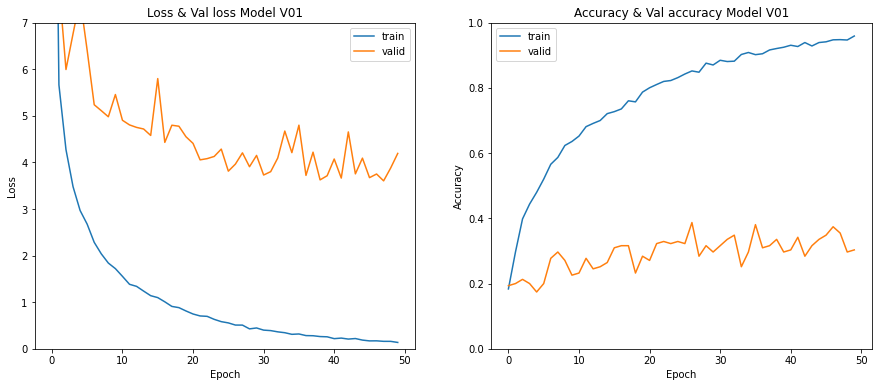

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_modelV01.history['loss'])
plt.plot(history_modelV01.history['val_loss'])
plt.ylim([0.0, 7.0])
plt.title("Loss & Val loss Model V01")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_modelV01.history['accuracy'])
plt.plot(history_modelV01.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V01")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

#### Results Model V01

**Save each model and test on 10 random images all of them. You have to save them on Google drive in order to give a link to the Professors!**

In [ ]:
# GET THE MINIMUM ACCURACY, THE MAXIMUM ACCURACY, THE MINIMUM LOSS, THE MAXIMUM LOSS AND SAVE THEM IN VARIABLES.
# THEN CREATE A DATAFRAME AT THE END WHERE YOU CAN COMPARE DIFFERENT MODELS WITH IT!

# LOSS/VAL LOSS
modelV01_minLoss = min(history_modelV01.history['loss'])
modelV01_maxLoss = max(history_modelV01.history['loss'])
modelV01_minValLoss = min(history_modelV01.history['val_loss'])
modelV01_maxValLoss = max(history_modelV01.history['val_loss'])

# ACCURACY/VAL ACCURACY
modelV01_minAccuracy = min(history_modelV01.history['accuracy'])
modelV01_maxAccuracy = max(history_modelV01.history['accuracy'])
modelV01_minValAccuracy = min(history_modelV01.history['val_accuracy'])
modelV01_maxValAccuracy = max(history_modelV01.history['val_accuracy'])

# CREATE THE DATAFRAME
modelV01_loss_accuracy = pd.DataFrame({"minLoss": [modelV01_minLoss],
                                       "maxloss": [modelV01_maxLoss],
                                       "minValLoss": [modelV01_minValLoss],
                                       "maxValLoss": [modelV01_maxValLoss],
                                       "minAccuracy": [modelV01_minAccuracy],
                                       "maxAccuracy": [modelV01_maxAccuracy],
                                       "minValAccuracy": [modelV01_minValAccuracy],
                                       "maxValAccuracy": [modelV01_maxValAccuracy]}).T

# CHANGE THE FIRST COLUMN NAME
modelV01_loss_accuracy = modelV01_loss_accuracy.rename(columns={0: 'modelV01'})
# CHANGE THE INDEX NAME
modelV01_loss_accuracy.index.names = ['Performance']
modelV01_loss_accuracy

In [ ]:
keras_file_modelV01 = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/modelV01.h5"
tf.keras.models.save_model(net_modelV01, keras_file_modelV01) # MODIFY MODEL WITH YOUR OWN MODEL

<IPython.core.display.Javascript object>

### 5.1.2 Model V02 - Model with regularization, Batch normalization and double Dense layer

In [ ]:
# Architecture definition V02
inputs = keras.Input((SIZE,SIZE,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

net_modelV02 = keras.Model(inputs, outputs)

net_modelV02.summary()

<IPython.core.display.Javascript object>

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496 

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1qKA348F045qujsBUp-TlWSui43jTvVM5' />
<figcaption>Architecture ModelV02</figcaption></center>
</figure>

In [ ]:
# COMPILE THE MODEL
net_modelV02.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.RMSprop(learning_rate=0.0001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
# START COUNTING THE TIME
start = datetime.datetime.now()

history_modelV02 = net_modelV02.fit(train_dataset, 
                           epochs=50, 
                           validation_data = test_dataset,
                           callbacks = [callback])

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

<IPython.core.display.Javascript object>

Epoch 1/50
113/113 [==============================] - 706s 6s/step - loss: 2.0909 - accuracy: 0.4426 - val_loss: 2.1288 - val_accuracy: 0.3355
Epoch 2/50
113/113 [==============================] - 4s 33ms/step - loss: 1.3302 - accuracy: 0.6889 - val_loss: 1.8931 - val_accuracy: 0.3677
Epoch 3/50
113/113 [==============================] - 4s 33ms/step - loss: 1.0627 - accuracy: 0.7809 - val_loss: 1.7225 - val_accuracy: 0.4710
Epoch 4/50
113/113 [==============================] - 4s 32ms/step - loss: 0.8762 - accuracy: 0.8580 - val_loss: 1.7243 - val_accuracy: 0.4710
Epoch 5/50
113/113 [==============================] - 4s 32ms/step - loss: 0.7389 - accuracy: 0.9057 - val_loss: 1.8457 - val_accuracy: 0.4065
Epoch 6/50
113/113 [==============================] - 4s 32ms/step - loss: 0.6491 - accuracy: 0.9262 - val_loss: 1.6771 - val_accuracy: 0.4839
Epoch 7/50
113/113 [==============================] - 4s 31ms/step - loss: 0.5725 - accuracy: 0.9445 - val_loss: 1.5210 - val_accuracy: 0.5484

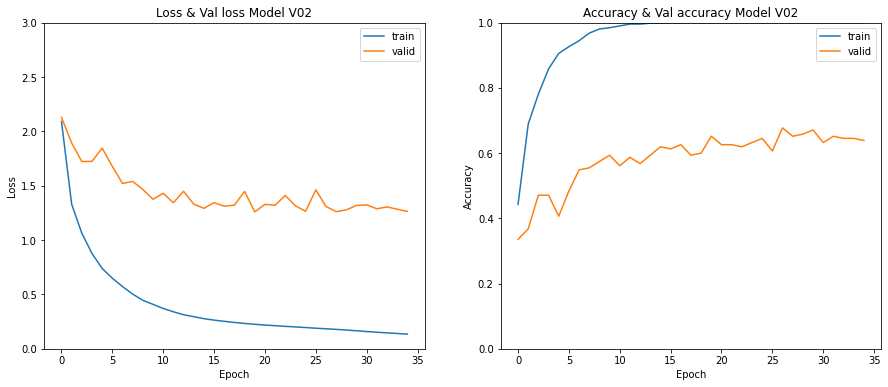

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_modelV02.history['loss'])
plt.plot(history_modelV02.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.title("Loss & Val loss Model V02")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_modelV02.history['accuracy'])
plt.plot(history_modelV02.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V02")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

#### Results Model V02

In [ ]:
# GET THE MINIMUM ACCURACY, THE MAXIMUM ACCURACY, THE MINIMUM LOSS, THE MAXIMUM LOSS AND SAVE THEM IN VARIABLES.
# THEN CREATE A DATAFRAME AT THE END WHERE YOU CAN COMPARE DIFFERENT MODELS WITH IT!

# LOSS/VAL LOSS
modelV02_minLoss = min(history_modelV02.history['loss'])
modelV02_maxLoss = max(history_modelV02.history['loss'])
modelV02_minValLoss = min(history_modelV02.history['val_loss'])
modelV02_maxValLoss = max(history_modelV02.history['val_loss'])

# ACCURACY/VAL ACCURACY
modelV02_minAccuracy = min(history_modelV02.history['accuracy'])
modelV02_maxAccuracy = max(history_modelV02.history['accuracy'])
modelV02_minValAccuracy = min(history_modelV02.history['val_accuracy'])
modelV02_maxValAccuracy = max(history_modelV02.history['val_accuracy'])

# CREATE THE DATAFRAME
modelV02_loss_accuracy = pd.DataFrame({"minLoss": [modelV02_minLoss],
                                       "maxloss": [modelV02_maxLoss],
                                       "minValLoss": [modelV02_minValLoss],
                                       "maxValLoss": [modelV02_maxValLoss],
                                       "minAccuracy": [modelV02_minAccuracy],
                                       "maxAccuracy": [modelV02_maxAccuracy],
                                       "minValAccuracy": [modelV02_minValAccuracy],
                                       "maxValAccuracy": [modelV02_maxValAccuracy]}).T

# CHANGE THE FIRST COLUMN NAME
modelV02_loss_accuracy = modelV02_loss_accuracy.rename(columns={0: 'modelV02'})
# CHANGE THE INDEX NAME
modelV02_loss_accuracy.index.names = ['Performance']
modelV02_loss_accuracy

In [ ]:
# SAVE THE MODEL V02
keras_file_modelV02 = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/modelV02.h5"
tf.keras.models.save_model(net_modelV02, keras_file_modelV02) # MODIFY MODEL WITH YOUR OWN MODEL

<IPython.core.display.Javascript object>

### 5.1.3 Model V03 - Training the model with Data Agmentation from keras (regularization and dropout)

In [ ]:
# DATA AUGMENTATION ONLY ON THE TRAINING SET
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,
        rotation_range=45,
        fill_mode='nearest')  # randomly shift images vertically (fraction of total height))

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255) 
val_datagen = ImageDataGenerator(rescale=1./255) 

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
    base_path_train,
    target_size=(SIZE,SIZE),
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    seed = SEED_VALUE)

test_generator = test_datagen.flow_from_directory(
    base_path_test,
    target_size=(SIZE,SIZE),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
    seed = SEED_VALUE)

# val_generator = val_datagen.flow_from_directory(
#     base_path_val,
#     target_size=(SIZE,SIZE),
#     batch_size=batch_size,
#     shuffle=False,
#     class_mode="categorical",
#     seed = SEED_VALUE)

<IPython.core.display.Javascript object>

Found 1803 images belonging to 9 classes.
Found 155 images belonging to 9 classes.
Found 192 images belonging to 9 classes.


In [ ]:
# ARCHITECTURE DEFINITION FOR MODEL V03
inputs = keras.Input((SIZE,SIZE,3))

x = inputs

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(512, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.GlobalMaxPooling2D()(x)

# ADD FLATTEN LAYER
x = tf.keras.layers.Flatten()(x)
# ADD DROPOUT LAYER
x = keras.layers.Dropout(.15)(x)

x = keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

net_modelV03 = keras.Model(inputs, outputs)

# PRINT THE SUMMARY
net_modelV03.summary()

<IPython.core.display.Javascript object>

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_3 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1849

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1WMiCo7jjyvtIw3VJW0T0aUDjBMC8Dyaq' />
<figcaption>Architecture ModelV03</figcaption></center>
</figure>

In [ ]:
# COMPILE THE MODEL
net_modelV03.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
# START COUNTING THE TIME
start = datetime.datetime.now()

# FIT THE MODEL
history_modelV03 = net_modelV03.fit(train_generator, 
                  validation_data = val_generator, # test_generator
                  steps_per_epoch = train_generator.n // train_generator.batch_size,
                  validation_steps = val_generator.n // val_generator.batch_size, # test_generator
                  epochs=50,
                  callbacks = [callback])

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

<IPython.core.display.Javascript object>

Epoch 1/50
112/112 [==============================] - 161s 1s/step - loss: 3.9061 - accuracy: 0.4141 - val_loss: 4.3590 - val_accuracy: 0.1771
Epoch 2/50
112/112 [==============================] - 9s 84ms/step - loss: 3.4093 - accuracy: 0.5848 - val_loss: 4.3848 - val_accuracy: 0.1615
Epoch 3/50
112/112 [==============================] - 9s 84ms/step - loss: 3.2299 - accuracy: 0.6542 - val_loss: 3.7984 - val_accuracy: 0.4375
Epoch 4/50
112/112 [==============================] - 10s 85ms/step - loss: 3.0551 - accuracy: 0.7096 - val_loss: 3.5439 - val_accuracy: 0.5156
Epoch 5/50
112/112 [==============================] - 10s 86ms/step - loss: 2.9301 - accuracy: 0.7476 - val_loss: 3.6912 - val_accuracy: 0.4115
Epoch 6/50
112/112 [==============================] - 10s 91ms/step - loss: 2.8781 - accuracy: 0.7487 - val_loss: 3.5380 - val_accuracy: 0.5104
Epoch 7/50
112/112 [==============================] - 9s 83ms/step - loss: 2.7868 - accuracy: 0.7818 - val_loss: 4.4682 - val_accuracy: 0.3

In [ ]:
# Iterazioni (numero al di sotto delle epoche) viene calcolato come shape del training (in termini di lunghezza)/numero di epoche.
# Esempio: se lunghezza di training è 1803 la si divide per batch size di 64 e si ottiene 28 iterazioni per epoca! --> to see all 
# the datapoints it need 28 iterations.

In [ ]:
# SHOW DIFFERENT TRAINING EPOCHS: USE 40/70/100 TRAINING EPOCHS AND SHOW/COMMENT THE RESULTS!
# UTILE PER CAPIRE STEPS PER EPOCH AND VALIDATION STEPS: https://datascience.stackexchange.com/questions/47405/what-to-set-in-steps-per-epoch-in-keras-fit-generator

<IPython.core.display.Javascript object>

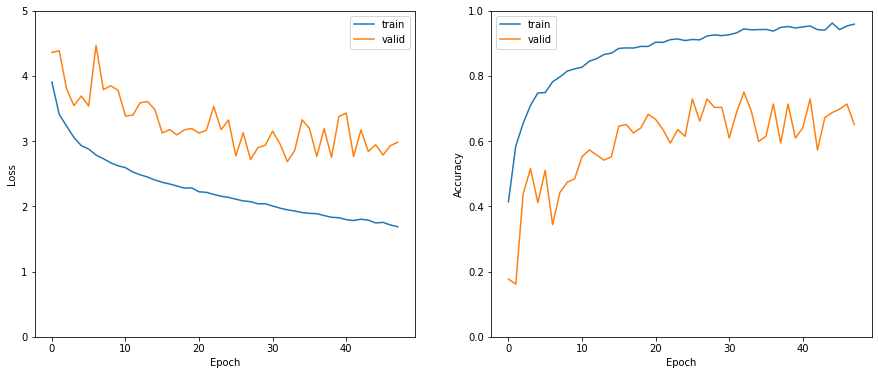

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

# VISUALIZZIAMO NUOVAMENTE L'OUTPUT IN TERMINI DI LOSS FUNCTION
plt.subplot(1, 2, 1)
plt.plot(history_modelV03.history['loss'])
plt.plot(history_modelV03.history['val_loss'])
plt.ylim([0.0, 5.0]) # è difficile da dire a priori
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_modelV03.history['accuracy'])
plt.plot(history_modelV03.history['val_accuracy'])
plt.ylim([0.0, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1. 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

TO CHECK:

- https://cs230.stanford.edu/projects_fall_2019/reports/26233496.pdf
- http://www.warse.org/IJETER/static/pdf/file/ijeter38892020.pdf
- https://www.kdnuggets.com/2022/05/image-classification-convolutional-neural-networks-cnns.html
- https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363

#### Results Model V03

In [ ]:
# GET THE MINIMUM ACCURACY, THE MAXIMUM ACCURACY, THE MINIMUM LOSS, THE MAXIMUM LOSS AND SAVE THEM IN VARIABLES.
# THEN CREATE A DATAFRAME AT THE END WHERE YOU CAN COMPARE DIFFERENT MODELS WITH IT!

# LOSS/VAL LOSS
modelV03_minLoss = min(history_modelV03.history['loss'])
modelV03_maxLoss = max(history_modelV03.history['loss'])
modelV03_minValLoss = min(history_modelV03.history['val_loss'])
modelV03_maxValLoss = max(history_modelV03.history['val_loss'])

# ACCURACY/VAL ACCURACY
modelV03_minAccuracy = min(history_modelV03.history['accuracy'])
modelV03_maxAccuracy = max(history_modelV03.history['accuracy'])
modelV03_minValAccuracy = min(history_modelV03.history['val_accuracy'])
modelV03_maxValAccuracy = max(history_modelV03.history['val_accuracy'])

# CREATE THE DATAFRAME
modelV03_loss_accuracy = pd.DataFrame({"minLoss": [modelV03_minLoss],
                                       "maxloss": [modelV03_maxLoss],
                                       "minValLoss": [modelV03_minValLoss],
                                       "maxValLoss": [modelV03_maxValLoss],
                                       "minAccuracy": [modelV03_minAccuracy],
                                       "maxAccuracy": [modelV03_maxAccuracy],
                                       "minValAccuracy": [modelV03_minValAccuracy],
                                       "maxValAccuracy": [modelV03_maxValAccuracy]}).T

# CHANGE THE FIRST COLUMN NAME
modelV03_loss_accuracy = modelV03_loss_accuracy.rename(columns={0: 'modelV03'})
# CHANGE THE INDEX NAME
modelV03_loss_accuracy.index.names = ['Performance']
modelV03_loss_accuracy

<IPython.core.display.Javascript object>

In [ ]:
# SAVE THE MODEL V03
keras_file_modelV03 = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/modelV03.h5"
tf.keras.models.save_model(net_modelV03, keras_file_modelV03) # MODIFY MODEL WITH YOUR OWN MODEL

<IPython.core.display.Javascript object>

EXAMPLE OF NOTES THAT YOU CAN ADD:

Note:

- The increased complexity does not appear to have improved the capability of the network.
- It has, however, impacted the validation accuracy curve, which is now converging faster.
- We will now address the current behavior to implement an early stopping mechanism.

Check the following:
- https://stackoverflow.com/questions/49017331/keras-flow-from-directorydirectory
- https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/

---------------------

### 5.1.4 MODEL V04 - Training the model with Data Agmentation from keras (regularization and higher dropout) - Deeper model

In [ ]:
# ARCHITECTURE FOUND AT: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
inputs = keras.Input((SIZE,SIZE,3))

x = inputs

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(512, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.GlobalMaxPooling2D()(x)

# the model so far outputs 3D feature maps (height, width, features)

# FLATTEN AND ADD DROPOUT
x = tf.keras.layers.Flatten()(x) # this converts our 3D feature maps to 1D feature vectors
x = keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.Dropout(.20)(x)
x = keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

net_modelv04 = keras.Model(inputs, outputs)

net_modelv04.summary()

<IPython.core.display.Javascript object>

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 activation_13 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1Zwvj-ZS4q82tea6xj7WHNNqhw_uOzd5U' />
<figcaption>Architecture ModelV03</figcaption></center>
</figure>

In [ ]:
net_modelv04.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
# START COUNTING THE TIME
start = datetime.datetime.now()

history_modelv04 = net_modelv04.fit(
    train_generator,
    steps_per_epoch = train_generator.n // train_generator.batch_size,
    epochs=50,
    validation_data = test_generator,
    validation_steps = test_generator.n // test_generator.batch_size,
    callbacks = [callback])

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

# model_keras.save_weights('first_try.h5')  # always save your weights after training or during training

<IPython.core.display.Javascript object>

Epoch 1/50
112/112 [==============================] - 12s 88ms/step - loss: 4.6059 - accuracy: 0.3179 - val_loss: 4.6673 - val_accuracy: 0.1736
Epoch 2/50
112/112 [==============================] - 10s 86ms/step - loss: 3.8158 - accuracy: 0.4874 - val_loss: 4.1953 - val_accuracy: 0.2014
Epoch 3/50
112/112 [==============================] - 9s 83ms/step - loss: 3.3841 - accuracy: 0.5333 - val_loss: 3.7128 - val_accuracy: 0.2917
Epoch 4/50
112/112 [==============================] - 9s 82ms/step - loss: 3.0672 - accuracy: 0.6100 - val_loss: 3.4495 - val_accuracy: 0.4792
Epoch 5/50
112/112 [==============================] - 9s 83ms/step - loss: 2.8531 - accuracy: 0.6469 - val_loss: 3.2810 - val_accuracy: 0.4444
Epoch 6/50
112/112 [==============================] - 9s 83ms/step - loss: 2.7023 - accuracy: 0.6805 - val_loss: 3.3462 - val_accuracy: 0.4653
Epoch 7/50
112/112 [==============================] - 9s 83ms/step - loss: 2.6059 - accuracy: 0.6933 - val_loss: 3.3234 - val_accuracy: 0.44

<IPython.core.display.Javascript object>

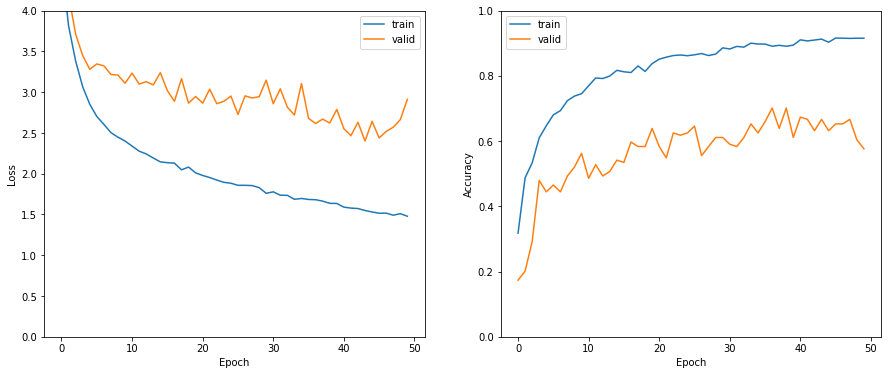

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

# VISUALIZZIAMO NUOVAMENTE L'OUTPUT IN TERMINI DI LOSS FUNCTION
plt.subplot(1, 2, 1)
plt.plot(history_modelv04.history['loss'])
plt.plot(history_modelv04.history['val_loss'])
plt.ylim([0.0, 4.0]) # è difficile da dire a priori
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_modelv04.history['accuracy'])
plt.plot(history_modelv04.history['val_accuracy'])
plt.ylim([0.0, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1. 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

#### Results Model V04

In [ ]:
# GET THE MINIMUM ACCURACY, THE MAXIMUM ACCURACY, THE MINIMUM LOSS, THE MAXIMUM LOSS AND SAVE THEM IN VARIABLES.
# THEN CREATE A DATAFRAME AT THE END WHERE YOU CAN COMPARE DIFFERENT MODELS WITH IT!

# LOSS/VAL LOSS
modelV04_minLoss = min(history_modelv04.history['loss'])
modelV04_maxLoss = max(history_modelv04.history['loss'])
modelV04_minValLoss = min(history_modelv04.history['val_loss'])
modelV04_maxValLoss = max(history_modelv04.history['val_loss'])

# ACCURACY/VAL ACCURACY
modelV04_minAccuracy = min(history_modelv04.history['accuracy'])
modelV04_maxAccuracy = max(history_modelv04.history['accuracy'])
modelV04_minValAccuracy = min(history_modelv04.history['val_accuracy'])
modelV04_maxValAccuracy = max(history_modelv04.history['val_accuracy'])

# CREATE THE DATAFRAME
modelV04_loss_accuracy = pd.DataFrame({"minLoss": [modelV04_minLoss],
                                       "maxloss": [modelV04_maxLoss],
                                       "minValLoss": [modelV04_minValLoss],
                                       "maxValLoss": [modelV04_maxValLoss],
                                       "minAccuracy": [modelV04_minAccuracy],
                                       "maxAccuracy": [modelV04_maxAccuracy],
                                       "minValAccuracy": [modelV04_minValAccuracy],
                                       "maxValAccuracy": [modelV04_maxValAccuracy]}).T

# CHANGE THE FIRST COLUMN NAME
modelV04_loss_accuracy = modelV04_loss_accuracy.rename(columns={0: 'modelV04'})
# CHANGE THE INDEX NAME
modelV04_loss_accuracy.index.names = ['Performance']
modelV04_loss_accuracy

<IPython.core.display.Javascript object>

,modelV04
Performance,
minLoss,1.478675
maxloss,4.605874
minValLoss,2.400862
maxValLoss,4.667253
minAccuracy,0.317851
maxAccuracy,0.916060
minValAccuracy,0.173611
maxValAccuracy,0.701389


In [ ]:
# SAVE THE MODEL V04
keras_file_modelV04 = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/modelV04.h5"
tf.keras.models.save_model(net_modelv04, keras_file_modelV04) # MODIFY MODEL WITH YOUR OWN MODEL

<IPython.core.display.Javascript object>

### 5.1.6 Model V06 - GRIDSEARCH

Ottima spiegazione:

- https://stackoverflow.com/questions/49160206/does-gridsearchcv-perform-cross-validation

- https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/#:~:text=Using%20Dropout%20on%20Hidden%20Layers,layer%20and%20the%20output%20layer.

Non stare ad applicare anche la cross validation, ma fai direttamente GRIDSEARCHCV che tiene in consideraziona ANCHE la cross validation!

Attenzione: "As you proceed through the examples in this post, you will aggregate the best parameters. This is not the best way to grid search because parameters can interact, but it is good for demonstration purposes." Based on this comment, you should create a single hypertuning parameter model because the parameters can interact between each others. O, altrimenti, potresti anche provarli uno per uno e poi spiegare che lßappendimento era troppo lungo per poter essere processato in una volta sola in Colab perche la macchina si disconnetteva (ci sono soluzioni a parte pagare?) 

#### Parameters tuning

In [ ]:
# USE THE FLOW FROM DIRECTORY ONLY FOR THE TRAIN BECAUSE THE GRIDSEARCHCV METHOD
# WILL CREATE ITS OWN TEST SET
itr = train_datagen.flow_from_directory(
    base_path_train,
    target_size=(SIZE,SIZE),
    batch_size=1803, # you flow through the entire training dataset and get all the images, using just one batch size!
    class_mode='categorical')

X, y = itr.next()

<IPython.core.display.Javascript object>

Found 1803 images belonging to 9 classes.


- https://stackoverflow.com/questions/42284873/assign-imagedatagenerator-result-to-numpy-array

**mantain this function in the same way as it is. the other architectures are ok like you have already done!**

In [ ]:
def create_GSCV_model(lr= 0.1, 
                      init_mode="he_uniform", 
                      activation = 'relu', 
                      dropout_rate= 0.0, 
                      optimizer = 'Adam'):
  
  model_gridsearchCV = tf.keras.models.Sequential([
  keras.Input((SIZE, SIZE, 3)),

  # 1st Conv Block
  keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 2nd Conv Block
  keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 3rd Conv block
  keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 4rd Conv block
  keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 5th Conv block
  keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 6th Conv block
  keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 7th Conv block
  keras.layers.Conv2D(512, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),

  # the model so far outputs 3D feature maps (height, width, features)

  # FLATTEN AND ADD DROPOUT
  keras.layers.Flatten(), # this converts our 3D feature maps to 1D feature vectors
  keras.layers.Dropout(0.20),
  keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),

  keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))
  ])

  # COMPILE THE MODEL
  model_gridsearchCV.compile(loss=keras.losses.categorical_crossentropy,
                             optimizer= keras.optimizers.Adam(learning_rate=lr),
                             metrics=['accuracy'],
                             steps_per_execution=5)

  return model_gridsearchCV

create_GSCV_model().summary()

<IPython.core.display.Javascript object>

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_33 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 activation_36 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_34 (Bat  (None, 32, 32, 32)      

In [ ]:
# CREATE THE MODEL
# model_gridsearchcv = KerasClassifier(model=model_gridsearchCV, epochs=20, verbose=10)
model_gridsearchcv = KerasClassifier(model = create_GSCV_model, # model = create_GSCV_model(), 
                                     epochs = 30,  
                                     lr = 0.1,
                                     verbose = 10,
                                     activation = 'relu',
                                     optimizer='Adam')

<IPython.core.display.Javascript object>

**COPIA QUANTO FATTO NELL'ALTRO NOTEBOOK PER QUESTA PARTE!**

In [ ]:
# DEFINE THE GRID SEARCH PARAMETERS
batch_size = [16, 32]
optimizer = ['SGD', 'Adam']
lr = [0.1, 0.01, 0.001, 0.0001]
activation = ['relu', 'LeakyRelu']

param_grid_CV = {
    'batch_size': batch_size,
    'optimizer': optimizer,
    'lr': lr,
    'activation': activation
}

# DEFINE THE GRIDSEARCHCV METHOD
# grid_cv = GridSearchCV(estimator=model_gridsearchcv, param_grid=param_grid, n_jobs = 1, cv=3, error_score="raise")
n_iter_search = 32 
grid_cv = RandomizedSearchCV(estimator = model_gridsearchcv, 
                             param_distributions = param_grid_CV, 
                             n_jobs = 1,
                             n_iter=n_iter_search,
                             cv = 3, 
                             error_score = "raise")

grid_cv

<IPython.core.display.Javascript object>

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=KerasClassifier(activation='relu', epochs=30, lr=0.1, model=<function create_GSCV_model at 0x7fc628214710>, optimizer='Adam', verbose=10),
                   n_iter=32, n_jobs=1,
                   param_distributions={'activation': ['relu', 'LeakyRelu'],
                                        'batch_size': [16, 32],
                                        'lr': [0.1, 0.01, 0.001, 0.0001],
                                        'optimizer': ['SGD', 'Adam']})

In [ ]:
# START COUNTING THE TIME
start = datetime.datetime.now()

# FIT THE GRIDSEARCH MODEL
grid_fit = grid_cv.fit(X, y)

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

<IPython.core.display.Javascript object>

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 2

In [ ]:
# SUMMARIZE RESULTS

print("Best: %f using %s" % (grid_fit.best_score_, grid_fit.best_params_))
means = grid_fit.cv_results_['mean_test_score']
stds = grid_fit.cv_results_['std_test_score']
params = grid_fit.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

<IPython.core.display.Javascript object>

Best: 0.728785 using {'optimizer': 'SGD', 'lr': 0.001, 'batch_size': 16, 'activation': 'relu'}
0.160843 (0.075841) with: {'optimizer': 'SGD', 'lr': 0.1, 'batch_size': 16, 'activation': 'relu'}
0.103716 (0.006972) with: {'optimizer': 'Adam', 'lr': 0.1, 'batch_size': 16, 'activation': 'relu'}
0.234054 (0.091885) with: {'optimizer': 'SGD', 'lr': 0.01, 'batch_size': 16, 'activation': 'relu'}
0.312257 (0.004150) with: {'optimizer': 'Adam', 'lr': 0.01, 'batch_size': 16, 'activation': 'relu'}
0.728785 (0.043728) with: {'optimizer': 'SGD', 'lr': 0.001, 'batch_size': 16, 'activation': 'relu'}
0.696062 (0.010197) with: {'optimizer': 'Adam', 'lr': 0.001, 'batch_size': 16, 'activation': 'relu'}
0.690516 (0.014184) with: {'optimizer': 'SGD', 'lr': 0.0001, 'batch_size': 16, 'activation': 'relu'}
0.714920 (0.006126) with: {'optimizer': 'Adam', 'lr': 0.0001, 'batch_size': 16, 'activation': 'relu'}
0.171381 (0.057511) with: {'optimizer': 'SGD', 'lr': 0.1, 'batch_size': 32, 'activation': 'relu'}
0.12534

#### Results Model V06

In [ ]:
# SAVE THE MODEL GRIDSEARCHCV
keras_file_gridsearchCV = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/model_gridsearchCV.h5"
tf.keras.models.save_model(create_GSCV_model(), keras_file_gridsearchCV) # MODIFY MODEL WITH YOUR OWN MODEL

<IPython.core.display.Javascript object>

**USE THID NEW PARAMETERS FOR FITTING THE BEST PREVIOUS MODEL AND SEE THE FINAL ACCURACY. SAVE THE FINAL MODEL. AFTER THIS, THEN TRANSFER LEARNING TO COMPARE THE RESULTS.**

### 5.1.6 MODEL V04_GRIDSEARCHCV - Retraining with best gridsearchCV parameters - Training the model with Data Agmentation from keras (regularization and dropout)

In [ ]:
# BEST PARAMETERS
batch_size_CV = 16
optimizer_CV = 'SGD'
learning_rate_CV = 0.001
activation_CV = 'relu'

# SE PERFORMANCE PEGGIORI, SECMPLICEMENTE STATE THE FACT AND PROCEED WITH TRANSFER LEARNING!
# DECISIONE CHE PRENDI, NEL CASO, PROPRIO PER QUESTO MOTIVO!

<IPython.core.display.Javascript object>

In [ ]:
# DATA AUGMENTATION ONLY ON THE TRAINING SET
train_datagen_CV = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,
        rotation_range=45,
        fill_mode='nearest')  # randomly shift images vertically (fraction of total height))

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen_CV = ImageDataGenerator(rescale=1./255) 
val_datagen_CV = ImageDataGenerator(rescale=1./255) 

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator_CV = train_datagen_CV.flow_from_directory(
    base_path_train,
    target_size=(SIZE,SIZE),
    batch_size=batch_size_CV,
    shuffle=True,
    class_mode="categorical",
    seed = SEED_VALUE)

test_generator_CV = test_datagen_CV.flow_from_directory(
    base_path_test,
    target_size=(SIZE,SIZE),
    batch_size=batch_size_CV,
    shuffle=False,
    class_mode="categorical",
    seed = SEED_VALUE)

val_generator_CV = val_datagen_CV.flow_from_directory(
    base_path_val,
    target_size=(SIZE,SIZE),
    batch_size=batch_size_CV,
    shuffle=False,
    class_mode="categorical",
    seed = SEED_VALUE)

<IPython.core.display.Javascript object>

Found 1803 images belonging to 9 classes.
Found 155 images belonging to 9 classes.
Found 192 images belonging to 9 classes.


In [ ]:
# ARCHITECTURE FOUND AT: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
inputs = keras.Input((SIZE,SIZE,3))

x = inputs

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation_CV)(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation_CV )(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation_CV)(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation_CV)(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation_CV)(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation_CV)(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(512, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation_CV)(x)
x = keras.layers.GlobalMaxPooling2D()(x)

# the model so far outputs 3D feature maps (height, width, features)

# FLATTEN AND ADD DROPOUT
x = tf.keras.layers.Flatten()(x) # this converts our 3D feature maps to 1D feature vectors
x = keras.layers.Dense(512, activation=activation_CV, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.Activation(activation_CV)(x)
x = keras.layers.Dropout(.20)(x)
x = keras.layers.Dense(512, activation=activation_CV, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

net_modelvGSCV = keras.Model(inputs, outputs)

net_modelvGSCV.summary()

<IPython.core.display.Javascript object>

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_106 (InputLayer)      [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_726 (Conv2D)         (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_726 (Ba  (None, 96, 96, 32)       128       
 tchNormalization)                                               
                                                                 
 activation_729 (Activation)  (None, 96, 96, 32)       0         
                                                                 
 max_pooling2d_622 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_727 (Conv2D)         (None, 32, 32, 32)        9248

In [ ]:
net_modelvGSCV.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.SGD(learning_rate=learning_rate_CV),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
# START COUNTING THE TIME
start = datetime.datetime.now()

history_modelv04_CV = net_modelvGSCV.fit(
        train_generator_CV,
        epochs=50, 
        steps_per_epoch = train_generator_CV.n // train_generator_CV.batch_size,
        validation_data = test_generator_CV,
        validation_steps = test_generator_CV.n // test_generator_CV.batch_size,
        callbacks = [callback])

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

<IPython.core.display.Javascript object>

Epoch 1/50
112/112 [==============================] - 11s 85ms/step - loss: 5.1672 - accuracy: 0.1623 - val_loss: 5.1807 - val_accuracy: 0.0556
Epoch 2/50
112/112 [==============================] - 10s 90ms/step - loss: 4.9839 - accuracy: 0.2792 - val_loss: 5.1629 - val_accuracy: 0.0833
Epoch 3/50
112/112 [==============================] - 9s 82ms/step - loss: 4.8854 - accuracy: 0.3218 - val_loss: 5.0296 - val_accuracy: 0.2569
Epoch 4/50
112/112 [==============================] - 9s 82ms/step - loss: 4.7529 - accuracy: 0.3744 - val_loss: 4.9052 - val_accuracy: 0.2778
Epoch 5/50
112/112 [==============================] - 9s 82ms/step - loss: 4.6695 - accuracy: 0.4068 - val_loss: 4.8639 - val_accuracy: 0.2847
Epoch 6/50
112/112 [==============================] - 10s 88ms/step - loss: 4.6041 - accuracy: 0.4219 - val_loss: 4.8644 - val_accuracy: 0.2569
Epoch 7/50
112/112 [==============================] - 9s 82ms/step - loss: 4.5297 - accuracy: 0.4460 - val_loss: 4.8261 - val_accuracy: 0.2

<IPython.core.display.Javascript object>

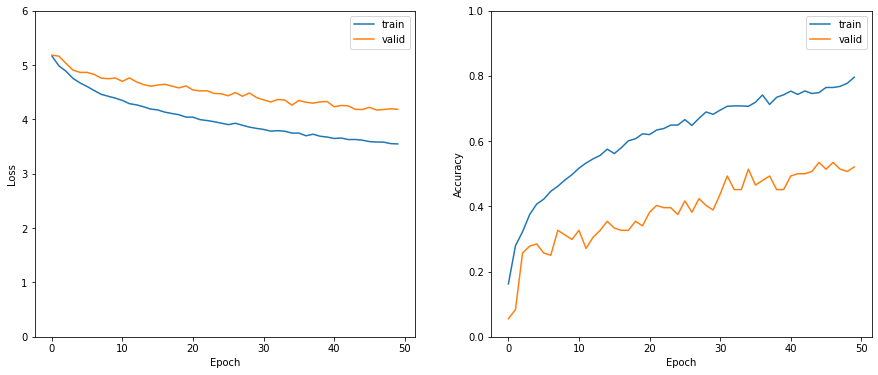

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

# VISUALIZZIAMO NUOVAMENTE L'OUTPUT IN TERMINI DI LOSS FUNCTION
plt.subplot(1, 2, 1)
plt.plot(history_modelv04_CV.history['loss'])
plt.plot(history_modelv04_CV.history['val_loss'])
plt.ylim([0.0, 6.0]) # è difficile da dire a priori
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_modelv04_CV.history['accuracy'])
plt.plot(history_modelv04_CV.history['val_accuracy'])
plt.ylim([0.0, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1. 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

#### Results Model V04 GRIDSEARCHCV

In [ ]:
# SAVE THE MODEL GRIDSEARCHCV
keras_file_modelV04_gridsearchCV = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/modelV04_GSCV.h5"
tf.keras.models.save_model(net_modelvGSCV, keras_file_modelV04_gridsearchCV) # MODIFY MODEL WITH YOUR OWN MODEL

<IPython.core.display.Javascript object>

In [ ]:
# GET THE MINIMUM ACCURACY, THE MAXIMUM ACCURACY, THE MINIMUM LOSS, THE MAXIMUM LOSS AND SAVE THEM IN VARIABLES.
# THEN CREATE A DATAFRAME AT THE END WHERE YOU CAN COMPARE DIFFERENT MODELS WITH IT!

# LOSS/VAL LOSS
modelV04_GDCV_minLoss = min(history_modelv04_CV.history['loss'])
modelV04_GDCV_maxLoss = max(history_modelv04_CV.history['loss'])
modelV04_GDCV_minValLoss = min(history_modelv04_CV.history['val_loss'])
modelV04_GDCV_maxValLoss = max(history_modelv04_CV.history['val_loss'])

# ACCURACY/VAL ACCURACY
modelV04_GDCV_minAccuracy = min(history_modelv04_CV.history['accuracy'])
modelV04_GDCV_maxAccuracy = max(history_modelv04_CV.history['accuracy'])
modelV04_GDCV_minValAccuracy = min(history_modelv04_CV.history['val_accuracy'])
modelV04_GDCV_maxValAccuracy = max(history_modelv04_CV.history['val_accuracy'])

# CREATE THE DATAFRAME
modelV04_GDCV_loss_accuracy = pd.DataFrame({"minLoss": [modelV04_GDCV_minLoss],
                                       "maxloss": [modelV04_GDCV_maxLoss],
                                       "minValLoss": [modelV04_GDCV_minValLoss],
                                       "maxValLoss": [modelV04_GDCV_maxValLoss],
                                       "minAccuracy": [modelV04_GDCV_minAccuracy],
                                       "maxAccuracy": [modelV04_GDCV_maxAccuracy],
                                       "minValAccuracy": [modelV04_GDCV_minValAccuracy],
                                       "maxValAccuracy": [modelV04_GDCV_maxValAccuracy]}).T

# CHANGE THE FIRST COLUMN NAME
modelV04_GDCV_loss_accuracy = modelV04_GDCV_loss_accuracy.rename(columns={0: 'modelV04_GDCV'})
# CHANGE THE INDEX NAME
modelV04_GDCV_loss_accuracy.index.names = ['Performance']
modelV04_GDCV_loss_accuracy

<IPython.core.display.Javascript object>

,modelV04_GDCV
Performance,
minLoss,3.547980
maxloss,5.167212
minValLoss,4.170539
maxValLoss,5.180653
minAccuracy,0.162283
maxAccuracy,0.795747
minValAccuracy,0.055556
maxValAccuracy,0.534722




---



---



### 5.1.7 Model V04 - Transfer learning with MOBILENETV2

USA QUESTO COME COMPARAZIONE:

- https://medium.com/analytics-vidhya/indian-food-image-classification-using-transfer-learning-b8878187ddd1

- https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

- https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/

- https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

- https://medium.com/analytics-vidhya/indian-food-image-classification-using-transfer-learning-b8878187ddd1

- https://medium.com/analytics-vidhya/indian-food-image-classification-using-transfer-learning-b8878187ddd1

- https://pyimagesearch.com/2016/08/10/imagenet-classification-with-python-and-keras/

QUALE ARCHITETTURA?

MOBILENET OR RESNET? APPLICALE ENTRAMBE E COMPARA RISULTATI SU ALMENO 50 EPOCHE!
- https://www.tertiaryinfotech.com/comparing-pre-trained-resnet-and-mobilenet/

The goal of using a pretrained model is that this model has been built to be very good at extracting useful features from images (it is called _feature extractor_).
The all convolutional layer that is not meant to do classification (the last layer) has the goal of extracting features from the images.
We will use those features in order to classify our data.

(ESTENDERE QUESTA SPIEGAZIONE IN MANIERA MIGLIORE!)

##### MOBILENETV2

https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299

Comparazione MOBILENETV2 e RESNET50:
- https://analyticsindiamag.com/mobilenet-vs-resnet50-two-cnn-transfer-learning-light-frameworks/

- https://www.tertiaryinfotech.com/comparing-pre-trained-resnet-and-mobilenet/

In [ ]:
# DATA AUGMENTATION ONLY ON THE TRAINING SET
train_datagen_mnetv2 = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,
        rotation_range=45,
        fill_mode='nearest')  # randomly shift images vertically (fraction of total height))

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen_mnetv2 = ImageDataGenerator(rescale=1./255) 
val_datagen_mnetv2 = ImageDataGenerator(rescale=1./255) 

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator_mnetv2 = train_datagen_mnetv2.flow_from_directory(
    base_path_train,
    target_size=(224,224),
    batch_size=batch_size_CV,
    shuffle=True,
    class_mode="categorical",
    seed = SEED_VALUE)

test_generator_mnetv2 = test_datagen_mnetv2.flow_from_directory(
    base_path_test,
    target_size=(224,224),
    batch_size=batch_size_CV,
    shuffle=False,
    class_mode="categorical",
    seed = SEED_VALUE)

# TOGLIERE: USARE SOLO NEL NOTEBOOK DI TEST!
# val_generator = val_datagen.flow_from_directory(
#     base_path_val,
#     target_size=(224,224),
#     batch_size=batch_size_CV,
#     shuffle=False,
#     class_mode="categorical",
#     seed = SEED_VALUE)

<IPython.core.display.Javascript object>

Found 1803 images belonging to 9 classes.
Found 155 images belonging to 9 classes.
Found 192 images belonging to 9 classes.


In [ ]:
# INSERISCI SITO E SPIEGAZIONE COME RIFERIMENTO: https://www.image-net.org/download.php

base_model_mobilenetv2 = tf.keras.applications.MobileNetV2(
    input_shape = (224, 224, 3),
    # include_top means: do you want to keep the classification layer, the final classification that the original model was training on.
    # MobileNetV2 was originally trained on the ImageNet dataset. Because the final layer has 1000 classes, if we would keep it, we
    # would have 1000 classes at the end. We do not want that but, instead, we want our own classification layer at the end.
    include_top=False, 
    # We keep the same weights
    weights="imagenet",
    # # Average pooling at the end: it will ensure that the output of the pretrained model is one-dimensional (with n classes).
    # pooling="avg"
)
# With the following we ensure that we do not mess with the original
# imagenet weights
base_model_mobilenetv2.trainable = False


x = base_model_mobilenetv2.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)
# We are using "softmax" since we want 9 probability values that all sum to 1 and the highest probability
# will be our classification result.
# For the regularizer: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-keras.md
preds = Dense(num_classes, activation='softmax')(x) #final layer with softmax activation for N classes

model_mobilenetv2 = keras.Model(inputs = base_model_mobilenetv2.input, outputs = preds) #specify the inputs and outputs

<IPython.core.display.Javascript object>

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# LOOK AT THE SUMMARY OF THE MODEL
print(model_mobilenetv2.summary())

<IPython.core.display.Javascript object>

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
# COMPILE THE MODEL
model_mobilenetv2.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
stepsEpochs = train_generator_mnetv2.n // 16
valSteps = test_generator_mnetv2.n // 16

# START COUNTING THE TIME
start = datetime.datetime.now()

# FIT THE MODEL
history_mobilenetV2 = model_mobilenetv2.fit(train_generator_mnetv2,
                                            validation_data = test_generator_mnetv2,
                                            steps_per_epoch = stepsEpochs,
                                            validation_steps = valSteps, 
                                            epochs=20, 
                                            callbacks = [callback])
                  
print("--- Training Completed ---")

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time: ", end-start)

<IPython.core.display.Javascript object>

Epoch 1/20
112/112 [==============================] - 457s 4s/step - loss: 1.0039 - accuracy: 0.7185 - val_loss: 0.4983 - val_accuracy: 0.8889
Epoch 2/20
112/112 [==============================] - 24s 215ms/step - loss: 0.2866 - accuracy: 0.9485 - val_loss: 0.3243 - val_accuracy: 0.9306
Epoch 3/20
112/112 [==============================] - 41s 363ms/step - loss: 0.1661 - accuracy: 0.9642 - val_loss: 0.2941 - val_accuracy: 0.9306
Epoch 4/20
112/112 [==============================] - 40s 358ms/step - loss: 0.1091 - accuracy: 0.9765 - val_loss: 0.2813 - val_accuracy: 0.9306
Epoch 5/20
112/112 [==============================] - 29s 257ms/step - loss: 0.0818 - accuracy: 0.9855 - val_loss: 0.2542 - val_accuracy: 0.9236
Epoch 6/20
112/112 [==============================] - 28s 249ms/step - loss: 0.0620 - accuracy: 0.9894 - val_loss: 0.2572 - val_accuracy: 0.9236
Epoch 7/20
112/112 [==============================] - 24s 216ms/step - loss: 0.0473 - accuracy: 0.9961 - val_loss: 0.2306 - val_accu

<IPython.core.display.Javascript object>

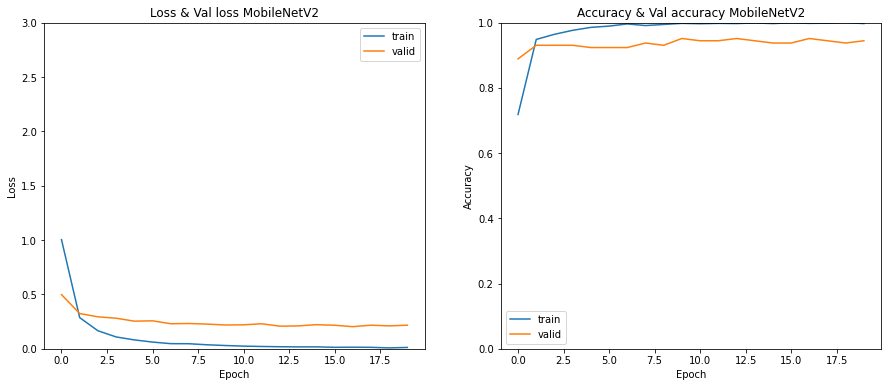

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_mobilenetV2.history['loss'])
plt.plot(history_mobilenetV2.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.title("Loss & Val loss MobileNetV2")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_mobilenetV2.history['accuracy'])
plt.plot(history_mobilenetV2.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy MobileNetV2")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [ ]:
# GET THE MINIMUM ACCURACY, THE MAXIMUM ACCURACY, THE MINIMUM LOSS, THE MAXIMUM LOSS AND SAVE THEM IN VARIABLES.
# THEN CREATE A DATAFRAME AT THE END WHERE YOU CAN COMPARE DIFFERENT MODELS WITH IT!

# LOSS/VAL LOSS
modelVMNV2_minLoss = min(history_mobilenetV2.history['loss'])
modelVMNV2_maxLoss = max(history_mobilenetV2.history['loss'])
modelVMNV2_minValLoss = min(history_mobilenetV2.history['val_loss'])
modelVMNV2_maxValLoss = max(history_mobilenetV2.history['val_loss'])

# ACCURACY/VAL ACCURACY
modelVMNV2_minAccuracy = min(history_mobilenetV2.history['accuracy'])
modelVMNV2_maxAccuracy = max(history_mobilenetV2.history['accuracy'])
modelVMNV2_minValAccuracy = min(history_mobilenetV2.history['val_accuracy'])
modelVMNV2_maxValAccuracy = max(history_mobilenetV2.history['val_accuracy'])

# CREATE THE DATAFRAME
modelVMNV2_loss_accuracy = pd.DataFrame({"minLoss": [modelVMNV2_minLoss],
                                       "maxloss": [modelVMNV2_maxLoss],
                                       "minValLoss": [modelVMNV2_minValLoss],
                                       "maxValLoss": [modelVMNV2_maxValLoss],
                                       "minAccuracy": [modelVMNV2_minAccuracy],
                                       "maxAccuracy": [modelVMNV2_maxAccuracy],
                                       "minValAccuracy": [modelVMNV2_minValAccuracy],
                                       "maxValAccuracy": [modelVMNV2_maxValAccuracy]}).T

# CHANGE THE FIRST COLUMN NAME
modelVMNV2_loss_accuracy = modelVMNV2_loss_accuracy.rename(columns={0: 'modelVMNV2'})
# CHANGE THE INDEX NAME
modelVMNV2_loss_accuracy.index.names = ['Performance']
modelVMNV2_loss_accuracy

<IPython.core.display.Javascript object>

,modelVMNV2
Performance,
minLoss,0.008312
maxloss,1.003903
minValLoss,0.203633
maxValLoss,0.498268
minAccuracy,0.718523
maxAccuracy,1.000000
minValAccuracy,0.888889
maxValAccuracy,0.951389


**Learning rate**
https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

The amount that the weights are updated during training is referred to as the step size or the “learning rate.”

Specifically, the learning rate is a configurable hyperparameter used in the training of neural networks that has a small positive value, often in the range between 0.0 and 1.0.

The learning rate controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs.

A learning rate that is too large can cause the model to converge too quickly to a suboptimal solution, whereas a learning rate that is too small can cause the process to get stuck.

The challenge of training deep learning neural networks involves carefully selecting the learning rate. It may be the most important hyperparameter for the model.

USEFUL LINKS:

BEST:
- https://medium.com/mlearning-ai/7-best-techniques-to-improve-the-accuracy-of-cnn-w-o-overfitting-6db06467182f
- https://sgugger.github.io/the-1cycle-policy.html

- https://www.paperspace.com/gradient/notebooks
- https://stats.stackexchange.com/questions/453221/should-i-use-gridsearchcv-on-all-of-my-data-or-just-the-training-set
- https://www.quora.com/What-kind-of-image-pre-processing-should-be-done-before-feeding-it-to-a-Convolutional-Neural-Network
- https://opt-ml.org/papers/2021/paper53.pdf
- https://towardsai.net/p/l/stop-using-grid-search-the-complete-practical-tutorial-on-keras-tuner
- https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/
- https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

###### Results Model V04 - MobileNetV2

#### RESNET50

https://medium.com/@nutanbhogendrasharma/image-classification-with-resnet50-model-12f4c79c216b#:~:text=keras%2Fmodels%2F.,other%20to%20form%20a%20network.

ATTENZIONE: DA MODIFICARE PERCHé CREZIONE SBAGLIATA, AFFIDARSI A QUANTO FATTO NELLA MOBILENETV2

In [ ]:
# INSERISCI SITO E SPIEGAZIONE COME RIFERIMENTO: https://www.image-net.org/download.php

pretrained_model_resnet50 = tf.keras.applications.ResNet50(
    input_shape = (224, 224, 3),
    # include_top means: do you want to keep the classification layer, the final classification that the original model was training on.
    # MobileNetV2 was originally trained on the ImageNet dataset. Because the final layer has 1000 classes, if we would keep it, we
    # would have 1000 classes at the end. We do not want that but, instead, we want our own classification layer at the end.
    include_top=False, 
    # We keep the same weights
    weights="imagenet",
    # Average pooling at the end: it will ensure that the output of the pretrained model is one-dimensional (with n classes).
    pooling="avg"
)

# With the following we ensure that we do not mess with the original
# imagenet weights
pretrained_model_resnet50.trainable = False

In [ ]:
# ARCHITECTURE DEFINITION FOR MODEL V04 PRETRAINED ON IMAGENET

model_pretrained_resnet50 = tf.keras.Sequential([
    pretrained_model, 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, 
                          activation="softmax",
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      ]
    )

In [ ]:
print(model_pretrained_resnet50.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 9)                 18441     
                                                                 
Total params: 23,606,153
Trainable params: 18,441
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [ ]:
model_pretrained_resnet50.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

In [ ]:
history_resnet50 = model_pretrained_resnet50.fit(train_generator, 
                  validation_data = test_generator, 
                  steps_per_epoch = train_generator.n // train_generator.batch_size,
                  validation_steps = test_generator.n // test_generator.batch_size, 
                  epochs=30) #,
                  # callbacks = [callback])

Epoch 1/30
112/112 [==============================] - 231s 2s/step - loss: 2.3727 - accuracy: 0.1058 - val_loss: 2.1891 - val_accuracy: 0.1458
Epoch 2/30
112/112 [==============================] - 237s 2s/step - loss: 2.2725 - accuracy: 0.1158 - val_loss: 2.1665 - val_accuracy: 0.3264
Epoch 3/30
112/112 [==============================] - 257s 2s/step - loss: 2.2518 - accuracy: 0.1253 - val_loss: 2.2194 - val_accuracy: 0.0347
Epoch 4/30
112/112 [==============================] - 230s 2s/step - loss: 2.2403 - accuracy: 0.1253 - val_loss: 2.2044 - val_accuracy: 0.0417
Epoch 5/30
112/112 [==============================] - 222s 2s/step - loss: 2.2018 - accuracy: 0.1528 - val_loss: 2.1858 - val_accuracy: 0.0694
Epoch 6/30
112/112 [==============================] - 227s 2s/step - loss: 2.2185 - accuracy: 0.1472 - val_loss: 2.1569 - val_accuracy: 0.0764
Epoch 7/30
112/112 [==============================] - 222s 2s/step - loss: 2.1886 - accuracy: 0.1477 - val_loss: 2.2001 - val_accuracy: 0.0417

SE I RISULTATI NON SONO BUONI è PERCHé LA RESNET è PIù GRANDE DELLA MOBILENETV2 CON MOLTI PIù PARAMETRI. CERFCA SE QUESTO POTREBBE ESSERE UN MOTIVO!

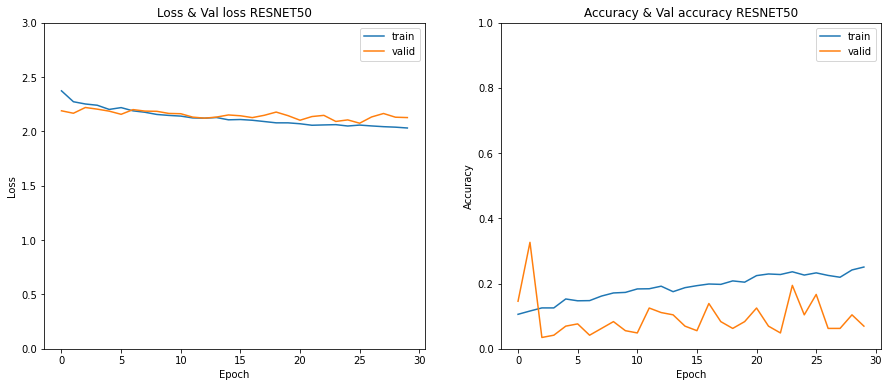

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.title("Loss & Val loss RESNET50")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy RESNET50")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

###### Results Model V04 - ResNet50

#### VGG16

ATTENZIONE: DA MODIFICARE PERCHé CREZIONE SBAGLIATA, AFFIDARSI A QUANTO FATTO NELLA MOBILENETV2

In [ ]:
# INSERISCI SITO E SPIEGAZIONE COME RIFERIMENTO: https://www.image-net.org/download.php

pretrained_model_VGG16 = tf.keras.applications.vgg16.VGG16(
    input_shape = (224, 224, 3),
    # include_top means: do you want to keep the classification layer, the final classification that the original model was training on.
    # MobileNetV2 was originally trained on the ImageNet dataset. Because the final layer has 1000 classes, if we would keep it, we
    # would have 1000 classes at the end. We do not want that but, instead, we want our own classification layer at the end.
    include_top=False, 
    # We keep the same weights
    weights="imagenet",
    # Average pooling at the end: it will ensure that the output of the pretrained model is one-dimensional (with n classes).
    pooling="avg"
)

# With the following we ensure that we do not mess with the original
# imagenet weights
pretrained_model_VGG16.trainable = False

58889256/58889256 [==============================] - 5s 0us/step


In [ ]:
# ARCHITECTURE DEFINITION FOR MODEL V04 PRETRAINED ON IMAGENET

pretrained_model_VGG16 = tf.keras.Sequential([
    pretrained_model_VGG16, 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, 
                          activation="softmax",
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      ]
    )

In [ ]:
# VISULIZE THE SUMMARY
print(pretrained_model_VGG16.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 9)                 4617      
                                                                 
Total params: 14,719,305
Trainable params: 4,617
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [ ]:
# COMPILE THE MODEL
pretrained_model_VGG16.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

In [ ]:
# FIT THE MODEL
history_VGG16 = pretrained_model_VGG16.fit(train_generator, 
                  validation_data = test_generator, 
                  steps_per_epoch = train_generator.n // train_generator.batch_size,
                  validation_steps = test_generator.n // test_generator.batch_size, 
                  epochs=5) #,
                  # callbacks = [callback])

print("--- Training Completed ---")

Epoch 1/30
112/112 [==============================] - 1635s 14s/step - loss: 2.4562 - accuracy: 0.1198 - val_loss: 2.4471 - val_accuracy: 0.0764
Epoch 2/30
112/112 [==============================] - 26s 234ms/step - loss: 2.2856 - accuracy: 0.1421 - val_loss: 2.2808 - val_accuracy: 0.1458
Epoch 3/30
112/112 [==============================] - 27s 241ms/step - loss: 2.2287 - accuracy: 0.1550 - val_loss: 2.1898 - val_accuracy: 0.1736
Epoch 4/30
112/112 [==============================] - 26s 235ms/step - loss: 2.1650 - accuracy: 0.1863 - val_loss: 2.1442 - val_accuracy: 0.2153
Epoch 5/30
112/112 [==============================] - 28s 247ms/step - loss: 2.1179 - accuracy: 0.2373 - val_loss: 2.1028 - val_accuracy: 0.2431
Epoch 6/30
112/112 [==============================] - 26s 234ms/step - loss: 2.0778 - accuracy: 0.2703 - val_loss: 2.0744 - val_accuracy: 0.2917
Epoch 7/30
112/112 [==============================] - 27s 236ms/step - loss: 2.0331 - accuracy: 0.3151 - val_loss: 2.0531 - val_ac

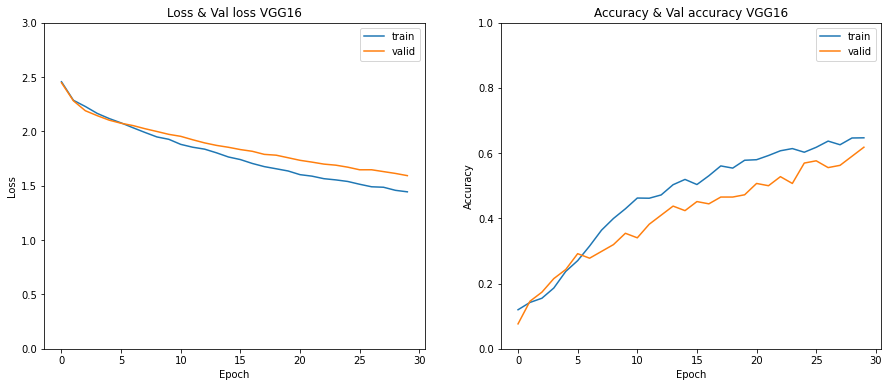

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_VGG16.history['loss'])
plt.plot(history_VGG16.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.title("Loss & Val loss VGG16")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy VGG16")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

###### Results Model V04 - VGG16

Convergence much slower than MobileNetV2. Why? (for sure better than ResNet50. Why?)

https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

### 5.1.8 Model V04 - Transfer learning + PCA

In [19]:
# Capture training data and labels into respective lists
train_images = []
train_labels = [] 

# GET THE LABELS
for directory_path in glob.glob(DIR_TRAIN_DATA):
    tr_label = directory_path.split("/")[-1]
    print(tr_label)
    # GET THE IMAGES
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        # print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(tr_label)

# CONVERT LISTS TO ARRAYS
train_images = np.array(train_images)
train_labels = np.array(train_labels)

################################################################
# CAPTURE TEST/VALIDATION DATA AND LABELS INTO RESPECTIVE LISTS

test_images = []
test_labels = [] 
for directory_path in glob.glob(DIR_TEST_DATA):
    tt_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(tt_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

<IPython.core.display.Javascript object>

french_fries
caprese_salad
pizza
greek_salad
sashimi
hot_dog
caesar_salad
hamburger
sushi


In [20]:
# ENCODE LABELS FROM TEXT TO INTEGERS
le = preprocessing.LabelEncoder()

# TRAIN DATA
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

# TEST DATA
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)

# SPLIT DATA INTO TEST AND TRAIN DATASETS (ALREADY SPLIT BUT ASSIGNING TO MEANINGFUL CONVENTION)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

<IPython.core.display.Javascript object>

In [21]:
# SCALE PIXEL VALUES BETWEEN 0 AND 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# ONE HOT ENCODE Y VALUES FOR NEURAL NETWORK
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

<IPython.core.display.Javascript object>

In [22]:
#############################
#Load VGG model with imagenet trained weights and without classifier/fully connected layers
#We will use this as feature extractor. 
base_model_mobilenetv2_PCA = tf.keras.applications.MobileNetV2(
    input_shape = (224, 224, 3),
    include_top=False, 
    weights="imagenet"
)
# With the following we ensure that we do not mess with the original
# imagenet weights
base_model_mobilenetv2_PCA.trainable = False
    
base_model_mobilenetv2_PCA.summary()  #Trainable parameters will be 0

<IPython.core.display.Javascript object>

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [23]:
# NOW, USE THE MOBILENETV2 AS A FEATURE EXTRACTOR
# TRAIN FEATURES
train_feature_extractor = base_model_mobilenetv2_PCA.predict(x_train)
train_features = train_feature_extractor.reshape(train_feature_extractor.shape[0], -1)

# TEST FEATURES
test_feature_extractor = base_model_mobilenetv2_PCA.predict(x_test)
test_features = test_feature_extractor.reshape(test_feature_extractor.shape[0], -1)

<IPython.core.display.Javascript object>

5/5 [==============================] - 6s 1s/step


In [63]:
train_features.shape

<IPython.core.display.Javascript object>

(1803, 62720)

In [80]:
# REDUCE DIMENSIONS USING PCA

#First verfiy the ideal number of PCA components to not lose much information. 
#Try to retain 90% information, so look where the curve starts to flatten.
#Remember that the n_components must be lower than the number of rows or columns (features)
pca_test = PCA(n_components=900) #
pca_test.fit(train_features)

<IPython.core.display.Javascript object>

PCA(n_components=900)

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Cumulative variance')

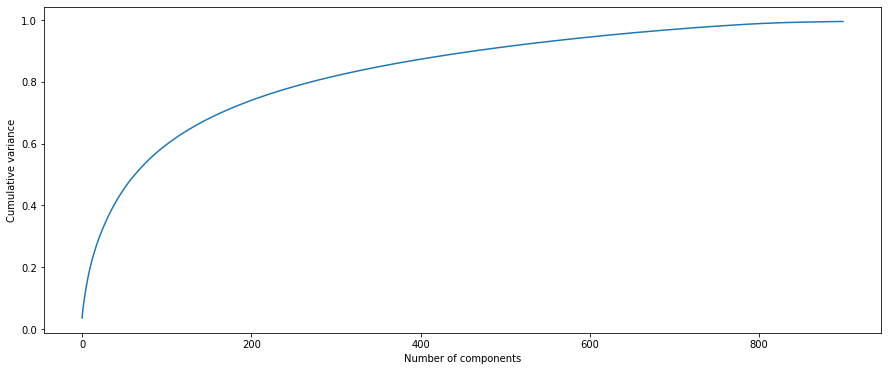

In [81]:
# Visualization of the cumulative variance plot
plt.figure(figsize=(15,6))

# PLOT THE RESULTS
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance")

In [83]:
# START COUNTING TIME
start = datetime.datetime.now()

#Pick the optimal number of components. This is how many features we will have 
#for our machine learning
n_PCA_components = 900
pca = PCA(n_components=n_PCA_components)
train_PCA = pca.fit_transform(train_features)
test_PCA = pca.transform(test_features) #Make sure you are just transforming, not fitting. 

end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

<IPython.core.display.Javascript object>

Total execution time with PCA is:  0:01:13.301501


In [84]:
train_PCA.shape

<IPython.core.display.Javascript object>

(1803, 900)

In [85]:
test_PCA.shape

<IPython.core.display.Javascript object>

(155, 900)

In [141]:
############## Neural Network Approach ##################

##Add hidden dense layers and final output/classifier layer.
model_PCA = Sequential()
inputs_PCA = keras.layers.Input(shape=(n_PCA_components,)) #Shape = n_components
hidden_1 = keras.layers.Dense(256, activation='relu')(inputs_PCA)
hidden_2 = keras.layers.Dense(512, activation='relu')(hidden_1)
#hidden1 = Dense(512, activation='relu')(inputs_PCA)
#hidden2 = Dense(256, activation='relu')(hidden1)
output_PCA = keras.layers.Dense(num_classes, activation='softmax')(hidden_2)
model_PCA = keras.Model(inputs = inputs_PCA, outputs = output_PCA)

# PRINT THE SUMMARY
print(model_PCA.summary())

# USING A LEARNING RATE DECAY/SCHEDULING --> https://keras.io/api/optimizers/
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps=10000,
    decay_rate=0.85) # previously 0.95

# COMPILE THE MODEL
model_PCA.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=lr_schedule), # 0.001 # 0.0001
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 900)]             0         
                                                                 
 dense_49 (Dense)            (None, 256)               230656    
                                                                 
 dense_50 (Dense)            (None, 512)               131584    
                                                                 
 dense_51 (Dense)            (None, 9)                 4617      
                                                                 
Total params: 366,857
Trainable params: 366,857
Non-trainable params: 0
_________________________________________________________________
None


In [142]:
# START RECORDING TIME
start = datetime.datetime.now()

#Fit the model and use on-hot-encoded Y values
history_model_PCA = model_PCA.fit(train_PCA, 
                                  y_train_one_hot, 
                                  epochs = 300, 
                                  verbose=10,
                                  validation_data=(test_PCA, y_test_one_hot))

# END RECORDING TIME
end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

<IPython.core.display.Javascript object>

Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Epoch 15/300
Epoch 16/300
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300
Epoch 28/300
Epoch 29/300
Epoch 30/300
Epoch 31/300
Epoch 32/300
Epoch 33/300
Epoch 34/300
Epoch 35/300
Epoch 36/300
Epoch 37/300
Epoch 38/300
Epoch 39/300
Epoch 40/300
Epoch 41/300
Epoch 42/300
Epoch 43/300
Epoch 44/300
Epoch 45/300
Epoch 46/300
Epoch 47/300
Epoch 48/300
Epoch 49/300
Epoch 50/300
Epoch 51/300
Epoch 52/300
Epoch 53/300
Epoch 54/300
Epoch 55/300
Epoch 56/300
Epoch 57/300
Epoch 58/300
Epoch 59/300
Epoch 60/300
Epoch 61/300
Epoch 62/300
Epoch 63/300
Epoch 64/300
Epoch 65/300
Epoch 66/300
Epoch 67/300
Epoch 68/300
Epoch 69/300
Epoch 70/300
Epoch 71/300
Epoch 72/300
Epoch 73/300
Epoch 74/300
Epoch 75/300
Epoch 76/300
Epoch 77/300
Epoch 78

In [143]:
##Predict on test dataset
predict_test_PCA = model_PCA.predict(test_PCA)
predict_test_PCA = np.argmax(predict_test_PCA, axis=1)
predict_test_PCA = le.inverse_transform(predict_test_PCA)

<IPython.core.display.Javascript object>

5/5 [==============================] - 0s 4ms/step


In [144]:
# INCRREASE DEEPNESS
##Print overall accuracy
print ("Accuracy = ", metrics.accuracy_score(test_labels, predict_test_PCA))

<IPython.core.display.Javascript object>

Accuracy =  0.9161290322580645


<IPython.core.display.Javascript object>

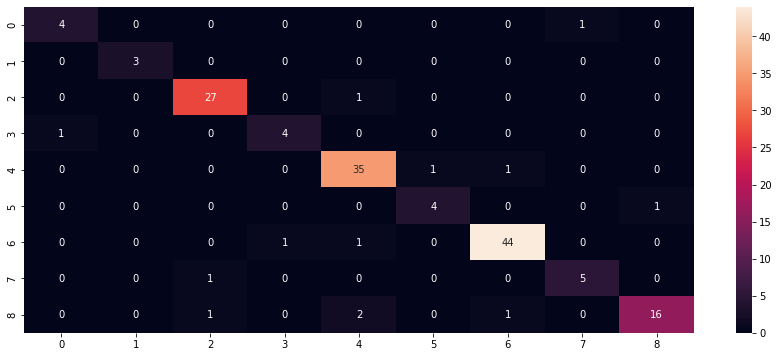

In [145]:
# Visualization of the confusion matrix
plt.figure(figsize=(15,6))

# CONFUSION MATRIX - VERIFY ACCURACY OF EACH CLASS

cm = confusion_matrix(test_labels, predict_test_PCA)
sns.heatmap(cm, annot=True)

<IPython.core.display.Javascript object>

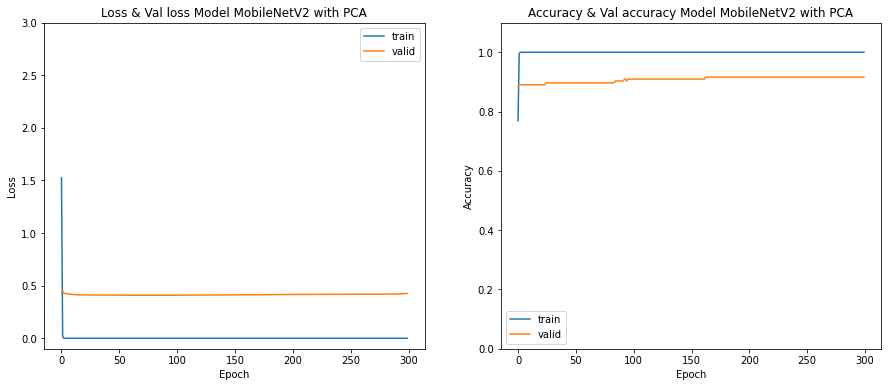

In [146]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_model_PCA.history['loss'])
plt.plot(history_model_PCA.history['val_loss'])
plt.ylim([-0.1, 3.0])
plt.title("Loss & Val loss Model MobileNetV2 with PCA")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_model_PCA.history['accuracy'])
plt.plot(history_model_PCA.history['val_accuracy'])
plt.ylim([0.0, 1.1])
plt.title("Accuracy & Val accuracy Model MobileNetV2 with PCA")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

**TRY WITH 10 DIFFERENT IMAGES TO SEE THE ACCURACY!!**

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 32ms/step
The prediction for this image is:  ['sushi']
The actual label for this image is:  sushi


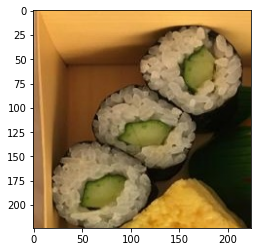

In [154]:
# CHECK RESULTS ON A FEW SELECTED IMAGES
n = np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)

# INPUT
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature = base_model_mobilenetv2_PCA.predict(input_img)
input_img_features = input_img_feature.reshape(input_img_feature.shape[0], -1)
input_img_PCA = pca.transform(input_img_features)

# PREDICTION
prediction_img = model_PCA.predict(input_img_PCA)
prediction_img = np.argmax(prediction_img, axis=1)
prediction_img = le.inverse_transform(prediction_img)  #Reverse the label encoder to original name

# PRINT RESULTS
print("The prediction for this image is: ", prediction_img)
print("The actual label for this image is: ", test_labels[n])

### 5.1.9 Save the best model to load it again in the TEST notebook

In [ ]:
keras_file = "mobilenetV2.h5"
tf.keras.models.save_model(model_mobilenetv2, keras_file) # MODIFY MODEL WITH YOUR OWN MODEL

<IPython.core.display.Javascript object>

# Refactoring the code:

* USE TYPE ANNOTATION:
  - https://towardsdatascience.com/type-annotations-in-python-d90990b172dc
  - https://blog.logrocket.com/understanding-type-annotation-python/

*   CONVERT REUSABLE CODE IN FUNCTIONS AND MOVE THEM TO THE UTILS.PY FILE

* YOU SHOULD ALSO GET THE CODE USED IN BOSCH FOR SAVING THE FINAL DATASET WITH ALL THE PERFOMANCE MEASURES AND TIME SPENT FOR EACH MODEL:
  - https://github.com/alessandro-maccario/Industry-Lab-project-private/blob/main/Notebooks/Part2_Training.ipynb



SPOSTARE: CROSS VALIDATION E GRIDSEARCHCV SOPRA! DEVONO STARE AL DI SOTTO DEI CUSTOM MODELS! UTILIZZA IPERPARAMETRI CHE HAI TROVATO IN GRIDSEARCH PER QUESTO ULTIMO MODELLO IN TERMINI DI TRANSFER LEARNING!

# References

- https://github.com/bnsreenu/python_for_microscopists/blob/master/176-multiclass_using_VGG_weights_PCA_NN_RF.py